In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2                                      
%matplotlib inline       
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator               
from tqdm import tqdm


from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


In [2]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../dogImages/train')
valid_files, valid_targets = load_dataset('../dogImages/valid')
test_files, test_targets = load_dataset('../dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../dogImages/train/*/"))]

In [3]:
len(train_targets)

6680

In [4]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

In [5]:
## find the list of labels and save them as a pandas data 
labels_train = []
labels_test = []

for i in range(train_files.shape[0]):
    labels_train.append(dog_names[np.argmax(train_targets[i])])
    
for i in range(test_files.shape[0]):
    labels_test.append(dog_names[np.argmax(test_targets[i])])

In [6]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:03<00:00, 273.88it/s]


### Data Augmentation

In [ ]:
## data augmentation
from keras.preprocessing.image import ImageDataGenerator

## create a generator that rotate, zoom and flip the images
traingen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1/255,
        shear_range=0.04,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip= False,
        fill_mode='nearest')
validgen = ImageDataGenerator(rescale=1/255)

## apply the generator on test and valid sets
traingen.fit(train_tensors)
validgen.fit(valid_tensors)

df_training = traingen.flow(train_tensors , train_targets , batch_size = 20)
df_validation = validgen.flow(valid_tensors , valid_targets, batch_size = 20)

## Creating VGG-Model to Classify Dog Breeds using Transfer Learning

We use the bottleneck features from a different pre-trained model. We have downloaded the pre-computed features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features



In [8]:
def other_bottleneck_features(path):
    bottleneck_features = np.load(path)
    train = bottleneck_features['train'] 
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    return train,valid,test

# VGG19 model

In [9]:
train_VGG19 , valid_VGG19, test_VGG19 = other_bottleneck_features('../bottleneck_features/DogVGG19Data.npz')

In [10]:
#VGG19 architecture
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=(train_VGG19.shape[1:])))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [11]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [12]:
### Training  the model.
checkpointer_VGG19 = ModelCheckpoint(filepath='../saved_models/weights.best.VGG19.hdf5', verbose=1 , save_best_only =True)

VGG19_model.fit(train_VGG19, train_targets,
                  validation_data = (valid_VGG19 , valid_targets),
                  epochs=25, batch_size=20, callbacks=[checkpointer_VGG19], verbose=1)

Epoch 1/25
  1/334 [..............................] - ETA: 57s - loss: 19.8541 - accuracy: 0.0500

2023-05-09 12:51:06.681523: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


297/334 [=========================>....] - ETA: 0s - loss: 7.5065 - accuracy: 0.2396
Epoch 1: val_loss improved from inf to 3.25560, saving model to ../saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 7.0580 - accuracy: 0.2597 - val_loss: 3.2556 - val_accuracy: 0.4587
Epoch 2/25
299/334 [=========================>....] - ETA: 0s - loss: 1.9385 - accuracy: 0.6261
Epoch 2: val_loss improved from 3.25560 to 2.30146, saving model to ../saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 1.9201 - accuracy: 0.6299 - val_loss: 2.3015 - val_accuracy: 0.6000
Epoch 3/25
297/334 [=========================>....] - ETA: 0s - loss: 1.0836 - accuracy: 0.7576
Epoch 3: val_loss improved from 2.30146 to 2.08290, saving model to ../saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 1.0918 - accuracy: 0.7570 - val_loss: 2.0829 - val_accuracy: 0.6467
Epoch 4/25

In [13]:
VGG19_model.load_weights('../saved_models/weights.best.VGG19.hdf5')

In [14]:
VGG19_model.save('../saved_models/VGG19_model.h5')

In [15]:
# a function that returns the prediction accuracy on test data
def evaluate_model (model, model_name,tensors,targets):
    predicted = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in tensors]
    test_accuracy = 100*np.sum(np.array(predicted)==np.argmax(targets, axis=1))/len(predicted)
    
    print (f'{model_name} accuracy on test data is {test_accuracy}%') 

In [16]:
evaluate_model(VGG19_model,"VGG19", test_VGG19, test_targets)

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step
VGG19 accuracy on test data is 72.8468899521531%


In [17]:
def extract_VGG19(tensor):
    from keras.applications.vgg19 import VGG19, preprocess_input
    return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [18]:
def VGG19_predict_breed (img_path):
    # extract the bottle neck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = VGG19_model.predict(bottleneck_feature) 
    
    ## return the breed
    return dog_names[np.argmax(predicted_vector)]

In [19]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def breed_identifier_vgg19(img_path):
    display_img(img_path)
    prediction = VGG19_predict_breed(img_path)
    return print (f"This dog is a {prediction}\n")

1/1 [==============================] - 0s 10ms/step
This dog is a 55.Curly-coated_retriever



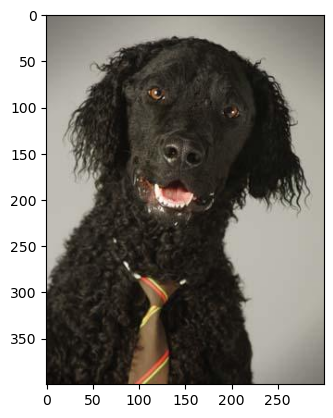

In [20]:
breed_identifier_vgg19('../dogImages/test/055.Curly-coated_retriever/Curly-coated_retriever_03870.jpg')


1/1 [==============================] - 0s 8ms/step
This dog is a 75.Glen_of_imaal_terrier



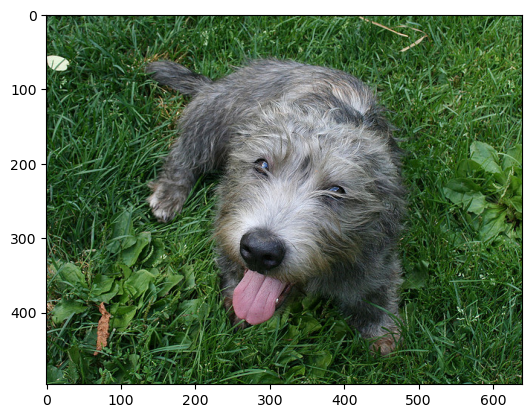

In [21]:
breed_identifier_vgg19('../dogImages/test/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05129.jpg')